In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
#try:
import torch
import torchvision
#    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
#except:
#    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#    import torch
#    import torchvision
#    print(f"torch version: {torch.__version__}")
#    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 35.97 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Getting Data

# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setting up Training and Test Paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [6]:
# Creating an EffNetB2 feature Extrator

import torchvision

effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 77.1MB/s]


In [7]:
# Freeze the base layers
for params in effnetb2.features.parameters():
    params.requires_grad = False

from torchinfo import summary
# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)


In [10]:
# Creating a function to make an EffNetB2 feature Extractor Model

def create_effnetb2_model(num_classes:int= 3,
                          seed:int = 42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  for params in model.parameters():
    params.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  ).to(device)

  return model, transforms


In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Prepare the Data for EffNetB2

from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [15]:
# Training EffNetB2 Feature Extractor
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=1,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409


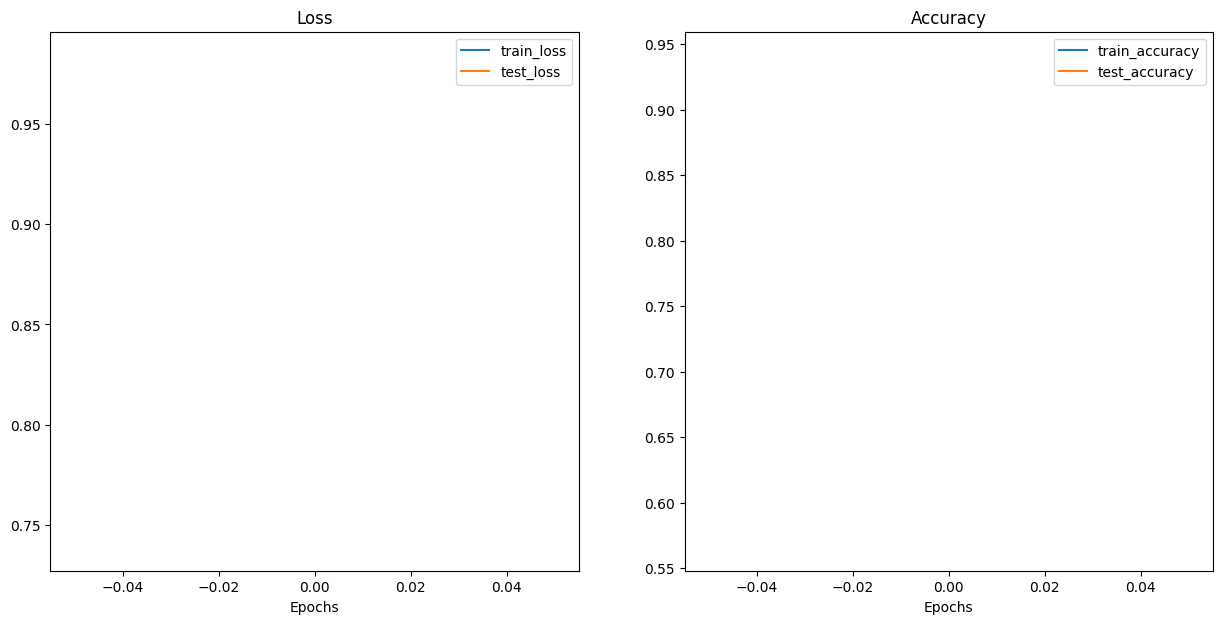

In [16]:
# Inspecting EffNetB2 Loss Curve

from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [17]:
# Save the Model to File

from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_feature_extractor_model.pth")


[INFO] Saving model to: models/effnetb2_feature_extractor_model.pth


In [18]:
# Inspecting the size of the EffNetB2 Model

from pathlib import Path

model_path = Path("models/effnetb2_feature_extractor_model.pth")
pretrained_effnetb2_model_size= model_path.stat().st_size/1024/1024
print(f"Model Size: {model_path.stat().st_size/1024/1024:.3f} MB")

Model Size: 29.838 MB


In [19]:
# Count number of Parameters in Effnetb2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
# Create a Dictionary with EffNetB2 statistics

effnetb2_statistics = {
    "model_name": "effnetb2_feature_extractor_model.pth",
    "model_size (MB)": pretrained_effnetb2_model_size,
    "model_params": effnetb2_total_params,
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    "model_results": effnetb2_results
}

effnetb2_statistics

{'model_name': 'effnetb2_feature_extractor_model.pth',
 'model_size (MB)': 29.83770179748535,
 'model_params': 7705221,
 'test_loss': 0.7393137812614441,
 'test_acc': 0.940909090909091,
 'model_results': {'train_loss': [0.9839188853899637],
  'train_acc': [0.5666666666666667],
  'test_loss': [0.7393137812614441],
  'test_acc': [0.940909090909091]}}

In [21]:
# ViT Model

vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )
  return model, transforms



In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 170MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
# Create DataLoader for ViT Model

from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names


(15, 5, ['pizza', 'steak', 'sushi'])

In [25]:
# Training ViT feature Extractor Model

from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results=engine.train(
    model=vit,
    train_dataloader=train_dataloader_vit,
    test_dataloader=test_dataloader_vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=1,
    device=device
)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381


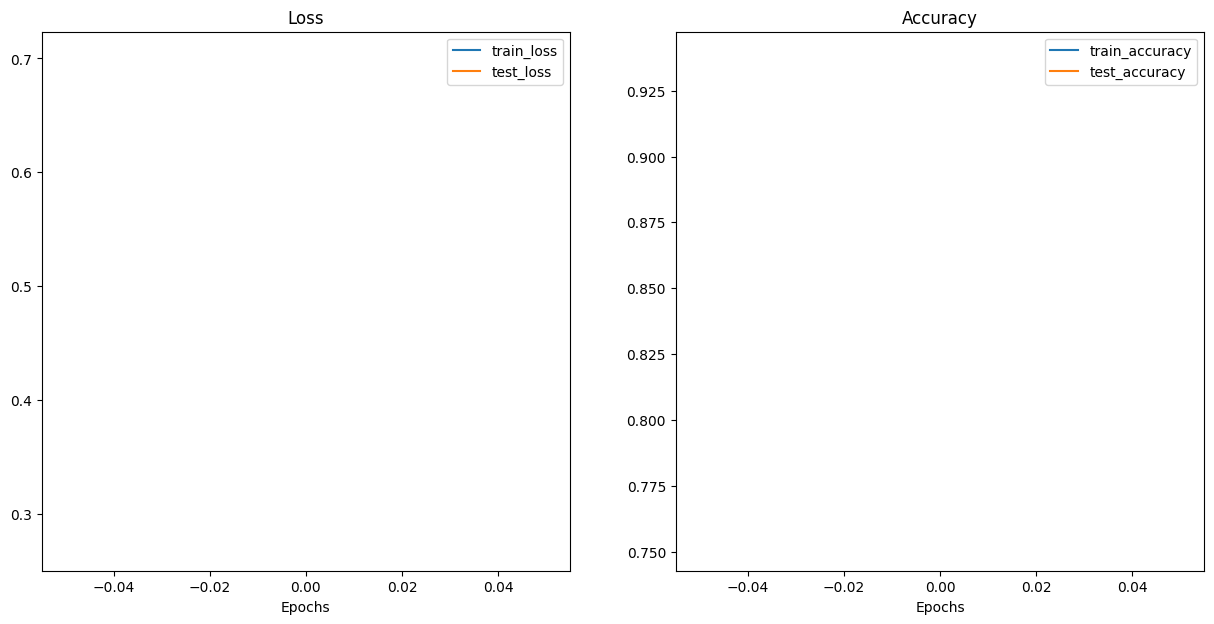

In [26]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [27]:
# Saving the model

from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="vit_feature_extractor_model.pth")

[INFO] Saving model to: models/vit_feature_extractor_model.pth


In [28]:
from pathlib import Path

model_path = Path("models/vit_feature_extractor_model.pth")
pretrained_vit_model_size= model_path.stat().st_size/1024/1024
print(f"Model Size: {model_path.stat().st_size/1024/1024:.3f} MB")

Model Size: 327.365 MB


In [29]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [30]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number of parameters": vit_total_params,
             "model size(MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.2713926836848259,
 'test_acc': 0.9380681818181819,
 'number of parameters': 85800963,
 'model size(MB)': 327.3652820587158}

In [31]:
# Making Prediction Timing

from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2716791.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/550687.jpg')]

In [32]:
from typing import List, Dict
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"):
  pred_list = []
  for path in tqdm(paths):
    pred_dict = {}
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name
    start_time = timer()
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(dim=0).to(device)
    model = model.to(device)
    model.eval()
    with torch.inference_mode():
      pred_logits = model(transformed_image)
      pred_prob = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prod"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      pred_dict["pred_class"] = pred_class
      end_time =  timer()
      pred_dict["pred_time"] = round(end_time - start_time,4)

    pred_dict["correct"] = class_name == pred_class
    pred_list.append(pred_dict)
  return pred_list



In [33]:
# Making and timing predictions with EffNetB2

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.4436,
  'pred_class': 'steak',
  'pred_time': 0.3623,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.4068,
  'pred_class': 'steak',
  'pred_time': 0.1226,
  'correct': True}]

In [35]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()


,image_path,class_name,pred_prod,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.4436,steak,0.3623,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.4068,steak,0.1226,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.4767,steak,0.1253,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.3686,steak,0.1367,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.4606,steak,0.1099,True


In [36]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,141
False,9


In [37]:
# Avg time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.pred_time.mean(),4)
effnetb2_average_time_per_pred


np.float64(0.1178)

In [38]:
effnetb2_statistics["average prediction time"] = effnetb2_average_time_per_pred
effnetb2_statistics

{'model_name': 'effnetb2_feature_extractor_model.pth',
 'model_size (MB)': 29.83770179748535,
 'model_params': 7705221,
 'test_loss': 0.7393137812614441,
 'test_acc': 0.940909090909091,
 'model_results': {'train_loss': [0.9839188853899637],
  'train_acc': [0.5666666666666667],
  'test_loss': [0.7393137812614441],
  'test_acc': [0.940909090909091]},
 'average prediction time': np.float64(0.1178)}

In [39]:
# Making and Timing Prediction with ViT

vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")
vit_test_pred_dicts[:2]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.8766,
  'pred_class': 'steak',
  'pred_time': 0.747,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.8564,
  'pred_class': 'steak',
  'pred_time': 0.5665,
  'correct': True}]

In [40]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.8766,
  'pred_class': 'steak',
  'pred_time': 0.747,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
  'class_name': 'steak',
  'pred_prod': 0.8564,
  'pred_class': 'steak',
  'pred_time': 0.5665,
  'correct': True}]

In [41]:
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prod,pred_class,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8766,steak,0.7470,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8564,steak,0.5665,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8558,steak,0.5617,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7455,steak,0.5817,True
4,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.4790,sushi,0.7930,False


In [42]:
vit_test_pred_df.correct.value_counts()


,count
correct,
True,141
False,9


In [43]:
vit_average_time_per_pred = round(vit_test_pred_df.pred_time.mean(),4)
vit_average_time_per_pred

np.float64(0.6214)

In [44]:
vit_stats["average prediction time"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.2713926836848259,
 'test_acc': 0.9380681818181819,
 'number of parameters': 85800963,
 'model size(MB)': 327.3652820587158,
 'average prediction time': np.float64(0.6214)}

In [45]:
# Compare results

df = pd.DataFrame([effnetb2_statistics, vit_stats])
df["model"]= ["EffNetB2", "ViT"]
df["test_acc"]=round(df.test_acc*100,2)
df = df.set_index("model")
df

,model_name,model_size (MB),model_params,test_loss,test_acc,model_results,average prediction time,number of parameters,model size(MB)
model,,,,,,,,,
EffNetB2,effnetb2_feature_extractor_model.pth,29.837702,7705221.0,0.739314,94.09,"{'train_loss': [0.9839188853899637], 'train_ac...",0.1178,NaN,NaN
ViT,NaN,NaN,NaN,0.271393,93.81,NaN,0.6214,85800963.0,327.365282


In [46]:
# Gradio App

!pip -q install gradio
import gradio as gr
print(gr.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.3 MB/s eta 0:00:00
5.22.0


In [47]:
# Create a function to map our input to output



In [48]:
effnetb2 = effnetb2.to("cpu")
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [49]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  start_time = timer()
  img = effnetb2_transforms(img).unsqueeze(dim=0)
  model = effnetb2
  model.eval()
  with torch.inference_mode():
    pred_logits = model(img)
    pred_probs = torch.softmax(pred_logits, dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  end_time = timer()
  pred_time = round(end_time - start_time, 4)
  return pred_labels_and_probs, pred_time

In [50]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]
image = Image.open(random_image_path)
print(f"Random Image Path: {random_image_path}\n")

pred_dict, pred_time = predict(img=image)
print(f"Prediction Time: {pred_time}\n")
print(f"Prediction Labels and Probabilities:\n{pred_dict}")


Random Image Path: data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg

Prediction Time: 0.1086

Prediction Labels and Probabilities:
{'pizza': 0.26316502690315247, 'steak': 0.24857257306575775, 'sushi': 0.488262414932251}


In [51]:
# Creating a list of Examples

example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2012780.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/831681.jpg']]

In [52]:
# Building the Gradio Interface

import gradio as gr

title = "FoodVision Mini"
description = "An EfficientNetB2 feature extractor computer vision model to classify Pizza, Sushi, Steak"
article = "Created by Xcode"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction Time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False,
            share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f97ee8e15c18f7f255.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [53]:
# Turning our Demo into a Deployable App

import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
  print(f"{foodvision_mini_demo_path} directory exists. Removing...")
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)


In [54]:
!ls demos/foodvision_mini/

In [55]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)


Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [56]:
import os

example_list = [["example/" + examples] for examples in os.listdir(foodvision_mini_examples_path)]
example_list

[['example/3622237.jpg'], ['example/592799.jpg'], ['example/2582289.jpg']]

In [57]:
# Get the Model


import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/effnetb2_feature_extractor_model.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the movel
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")



[INFO] Attempting to move models/effnetb2_feature_extractor_model.pth to demos/foodvision_mini/effnetb2_feature_extractor_model.pth
[INFO] Model move complete.


In [58]:
# model.py creation for Model Instance

%%writefile demos/foodvision_mini/model.py
import torch
from torch import nn
import torchvision

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms


Writing demos/foodvision_mini/model.py


In [59]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [60]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2. Model and transforms perparation ###
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_feature_extractor_model.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [61]:
# Creating requirements.txt

%%writefile demos/foodvision_mini/requriments.txt
torch==2.6.0
torchvision==0.21.0
gradio==5.21.0

Writing demos/foodvision_mini/requriments.txt


In [62]:
gr.__version__

'5.22.0'

In [63]:
# Deploying the app to Huggingface Spaces

!ls demos/foodvision_mini

app.py	effnetb2_feature_extractor_model.pth  examples	model.py  __pycache__  requriments.txt


In [64]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 54%)
  adding: effnetb2_feature_extractor_model.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: model.py (deflated 45%)
  adding: requriments.txt (deflated 13%)


In [65]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_mini.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_mini.zip manually.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:

# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/ignitingsprit/foodvision_mini/+", width=900, height=750)

In [67]:
# FoodVision Big with 101 classes

effnetb2_food101, effnetb2_food101_transforms = create_effnetb2_model(num_classes=101)

In [68]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [69]:
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [70]:
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [71]:
# Getting the Data for FoodVision Big

from torchvision import datasets
from pathlib import Path
data_dir = Path("data")
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food_101_train_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)


100%|██████████| 5.00G/5.00G [02:29<00:00, 33.4MB/s]


In [72]:
# Create a subnet of data for faster experiment

from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1
  print(f"Splitting dataset into {length_1} and {length_2}...")
  random_split_1, random_split_2= torch.utils.data.random_split(dataset,
                                                                lengths=[length_1,length_2],
                                                                generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [73]:
train_data_food101_20_percent, _= split_dataset(dataset=train_data,
                                                split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)


Splitting dataset into 15150 and 60600...
Splitting dataset into 5050 and 20200...


In [74]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

In [75]:
# Convert the dataset into DataLoaders

import torch
import os

NUM_WORKERS = 2
BATCH_SIZE= 23

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)



In [76]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(659, 220)

In [78]:
# Training FoodVision Big

from going_modular.going_modular import engine

optimizer =torch.optim.Adam(params=effnetb2_food101.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5871 | train_acc: 0.2828 | test_loss: 2.7100 | test_acc: 0.4900
Epoch: 2 | train_loss: 2.8335 | train_acc: 0.4406 | test_loss: 2.4374 | test_acc: 0.5396
Epoch: 3 | train_loss: 2.6545 | train_acc: 0.4801 | test_loss: 2.3409 | test_acc: 0.5675
Epoch: 4 | train_loss: 2.5747 | train_acc: 0.4973 | test_loss: 2.2951 | test_acc: 0.5737
Epoch: 5 | train_loss: 2.5207 | train_acc: 0.5127 | test_loss: 2.2633 | test_acc: 0.5822


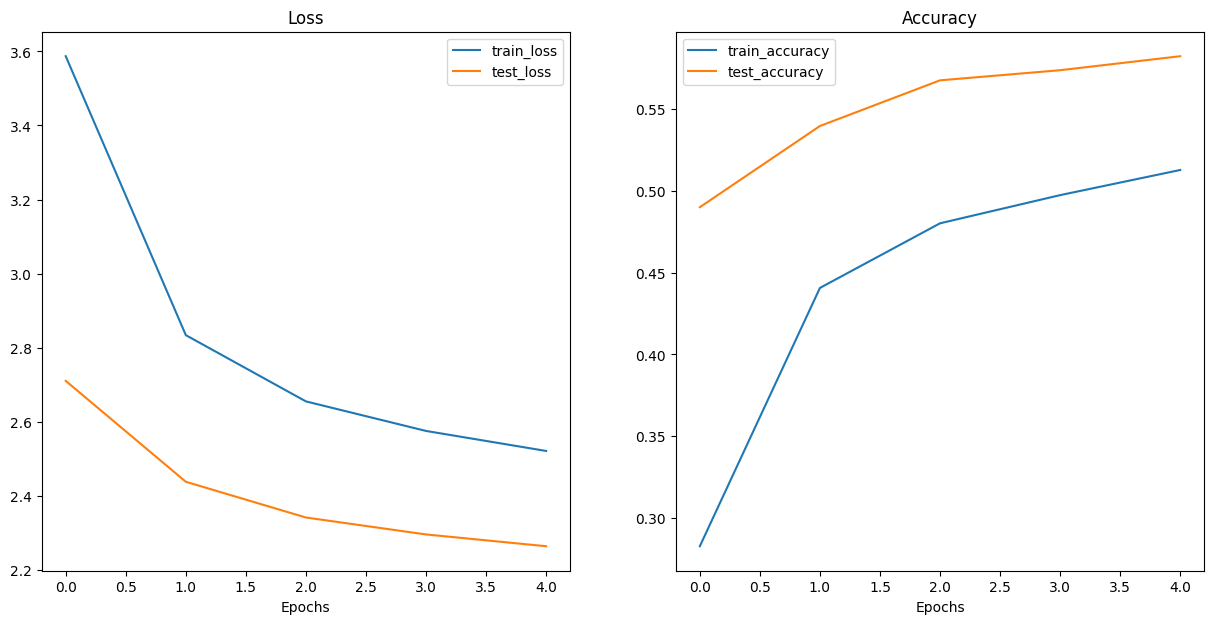

In [79]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

In [80]:
# Save Model

from going_modular.going_modular import utils

utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name="effnetb2_food101_model.pth")


[INFO] Saving model to: models/effnetb2_food101_model.pth


In [82]:
loaded_effnetb2_food101, effnetb2_tranformer = create_effnetb2_model(num_classes=101)

loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_food101_model.pth"))


<All keys matched successfully>

In [84]:
from pathlib import Path

pretrained_effnetb2_food101_model_size = Path("models/effnetb2_food101_model.pth").stat().st_size //(1024*1024)
print(f"Pretrained effnetb2 food101 model size: {pretrained_effnetb2_food101_model_size} MB")


Pretrained effnetb2 food101 model size: 30 MB


In [85]:
from pathlib import Path

foodvision_big_demo_path = Path("demos/foodvision_big/")

foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [86]:
# Download and move example image
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

--2025-03-19 19:21:57--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2025-03-19 19:21:58--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2025-03-19 19:21:58 (202 MB/s) - ‘04-pizza-dad.jpeg’ saved [

In [87]:
!mv models/effnetb2_food101_model.pth demos/foodvision_big/

In [90]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [92]:
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [93]:
with open(foodvision_big_class_names_path, "w") as f:
  f.write("\n".join(food101_class_names))

In [97]:
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [98]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_big/model.py


In [99]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

effnetb2.load_state_dict(
    torch.load(f"effnetb2_101_model.pth",
    map_location=torch.device("cpu"))
)


### 3. Predict function ###

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article
title = "FoodVision BIG 🍔👁💪"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images [101 classes of food from the Food101 dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)."

# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()


Writing demos/foodvision_big/app.py


In [100]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


In [106]:
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

2.6.0+cu124
0.21.0+cu124
5.22.0


In [101]:
# Change into the foodvision_big directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"


  adding: app.py (deflated 53%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_food101_model.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 46%)
  adding: requirements.txt (deflated 4%)


In [102]:
# Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print(f"Not running in Google Colab, can't use google.colab.files.download(), please download foodvision_big.zip manually.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>